<a href="https://colab.research.google.com/github/cc-ats/Tutorials/blob/main/ColabFoldTutorial_Monomer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%time

# @title **Install Python Packages** { run: "auto", display-mode: "form" }

import os
from sys import version_info
PYTHON_VERSION = f"{version_info.major}.{version_info.minor}"

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")


if not os.path.isfile("CONDA_READY"):
  print("installing conda...")
  os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
  os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
  os.system("conda config --set auto_update_conda false")
  os.system("touch CONDA_READY")


if not os.path.isfile("CONDA_READY"):
  print("installing conda...")
  os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
  os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
  os.system("mamba config --set auto_update_conda false")
  os.system("touch CONDA_READY")


if not os.path.isfile("HH_READY") and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")


installing colabfold...
installing conda...
installing hhsuite and amber...
CPU times: user 269 ms, sys: 52.3 ms, total: 321 ms
Wall time: 1min 24s


# 1. **ColabFold Tutorial:** Predicting the structure of Bax protein

Let's get familar with the workflow for predicting a monomer structure. This example looks at Bax, an apoptosis regulating protein.

We will only use the default options set by Steinegger *et al.* which excludes Amber minimization and structure templates.

**a. Background**
  - Encoded by the BAX gene in the Bcl-2 family
  - Highly conserved DNA sequence and structural motifs
  - Different regulatory function in anti-apoptosis or pro-apoptosis
  - Permeation of the mitochondrial outer membrane


**b. Pro-death signals triggers conformational shift**
  - Bax adopts a globular state when inactive
  - Apoptotic signals displaces N-terminal $\alpha$-helicies
  - Becomes membrane-associated
  - Oligomers form, resulting in a pore and cell death

Dysregulation of Bax is implicated in cancer progression, and suggests some contributions towards in Alzheimer's and Parkinson's disease.

Experiments have shown point-mutations near opposite of the binding site region, has been shown to affect activity. This is also near the loop region between $\alpha$-helix1 and $\alpha$-helicies2, which has been difficult to structurally resolve. Does this loop play a role in membrane insertion mechanism?


In [ ]:
#@title # **2. Notebook Setup** { display-mode: "form" }

from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

#@markdown \
#@markdown ##a. Protein Sequence for Structure Prediction
#@markdown For bax (human), the amino acid sequence was obtained from
#@markdown UniProt ([Q07812](https://www.uniprot.org/uniprotkb/Q07812/entry))
query_sequence = 'MDGSGEQPRGGGPTSSEQIMKTGALLLQGFIQDRAGRMGGEAPELALDPVPQDASTKKLSECLKRIGDELDSNMELQRMIAAVDTDSPREVFFRVAADMFSDGNFNWGRVVALFYFASKLVLKALCTKVPELIRTIMGWTLDFLRERLLGWIQDQGGWDGLLSYFGTPTWQTVTIFVAGVLTASLTIWKKMG' #@param {type:"string"}
#@markdown **Note:** For modeling complexes, use `:` to specify inter-protein chainbreaks
#@markdown (supports homo- and hetro-oligomers).
#@markdown For example, **PI...SK:PI...SK** for a homodimer.

#@markdown \
#@markdown ## b. Job Name (also name of saving directory)
jobname = 'colabfold-bax-1f16' #@param {type:"string"}

#@markdown \
#@markdown  ## c. Number of predicted models to relax using Amber
num_relax = 0 #@param [0, 1, 5] {type:"raw"}

#@markdown \
#@markdown ## **d. Option for Structure Template**
#@markdown  Search for PDB structure (xyz-coordinates)
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown `none` = no template information is used. \
#@markdown `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). \
#@markdown `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

query_sequence = "".join(query_sequence.split()) # remove whitespaces

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False


In [ ]:
#@title # **3. Multiple Sequence Alignment (MSA)**

#@markdown ## a. MSA options
msa_mode = "mmseqs2_uniref" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
#@markdown - pairing mode
#@markdown - single sequence
#@markdown - custom MSA upload

#@markdown \
pair_mode = "unpaired_paired" #@param ["unpaired_paired","unpaired","paired"] {type:"string"}
#@markdown - "unpaired_paired" - pair sequences from same species + unpaired MSA
#@markdown - "unpaired" - seperate MSA for each chain
#@markdown - "paired" - only use paired sequences

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [ ]:
# @title # **4. Advanced Settings** { run: "auto", display-mode: "form" }

#@markdown ## a. ML Model
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown **Note:** If `auto` selected, will use `alphafold2_ptm` for monomer prediction
#@markdown and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the `mode_types` can be used (regardless if input is monomer or complex).

#@markdown \
#@markdown ## b. Re-Train with Predicted Structures
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown **Note:**
#@markdown - If `auto` selected, will use `num_recycles=20`,
#@markdown - If `model_type=alphafold2_multimer_v3`, else `num_recycles=3`

#@markdown \
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5`
#@markdown - If `model_type=alphafold2_multimer_v3`,  else `tol=0.0`.

#@markdown \
#@markdown ## c. Amber Relaxation
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations
#@markdown -  `0` = unlimited (AlphaFold2 default, can take very long)

#@markdown \
#@markdown ## d. MSA Pairing
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets,
#@markdown - `complete` = all sequences have to match in one line.

#@markdown \
#@markdown ## e. Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown \
#@markdown # **5. Save settings**
#@markdown This will ask for your credentials, to save the outputs.
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2023-12-08 01:03:26,095 Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
2023-12-08 01:03:26,097 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2023-12-08 01:03:28,068 Running on GPU
2023-12-08 01:03:28,251 Found 3 citations for tools or databases
2023-12-08 01:03:28,252 Query 1/1: colabfoldbax1f16_f85cf (length 192)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


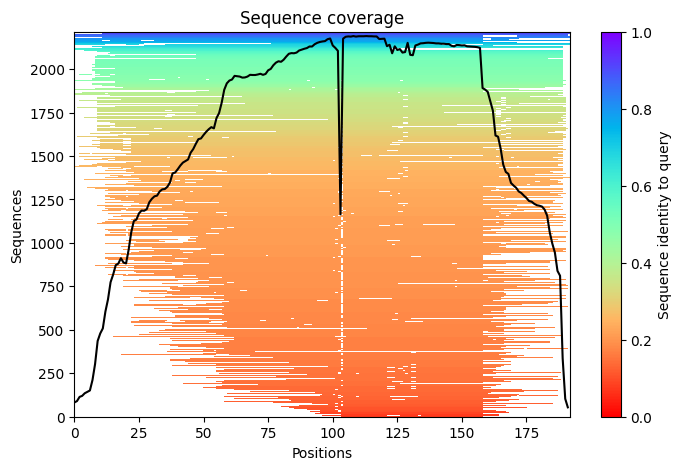

2023-12-08 01:03:32,044 Setting max_seq=512, max_extra_seq=1703
2023-12-08 01:04:07,724 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=70.2 pTM=0.694
2023-12-08 01:04:13,490 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=80.9 pTM=0.793 tol=1.07
2023-12-08 01:04:19,257 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=78.4 pTM=0.775 tol=0.281
2023-12-08 01:04:25,019 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=81.1 pTM=0.798 tol=0.165
2023-12-08 01:04:25,021 alphafold2_ptm_model_1_seed_000 took 39.0s (3 recycles)


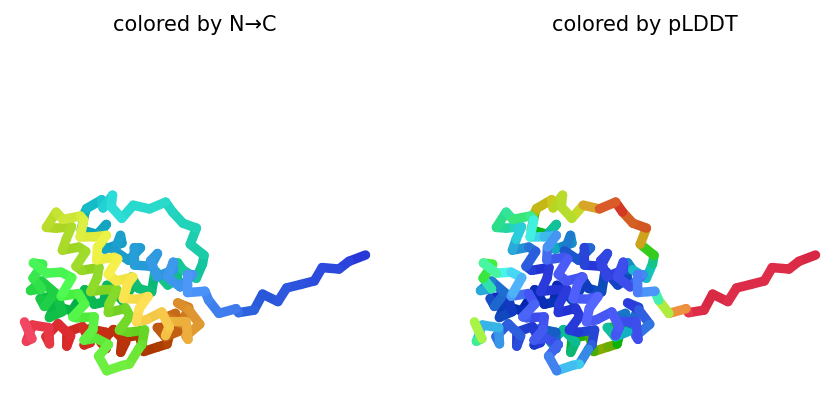

2023-12-08 01:04:31,023 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=68.3 pTM=0.67
2023-12-08 01:04:36,783 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=79.3 pTM=0.783 tol=1.21
2023-12-08 01:04:42,548 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=78.2 pTM=0.779 tol=0.353
2023-12-08 01:04:48,310 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=79.4 pTM=0.789 tol=0.121
2023-12-08 01:04:48,311 alphafold2_ptm_model_2_seed_000 took 23.1s (3 recycles)


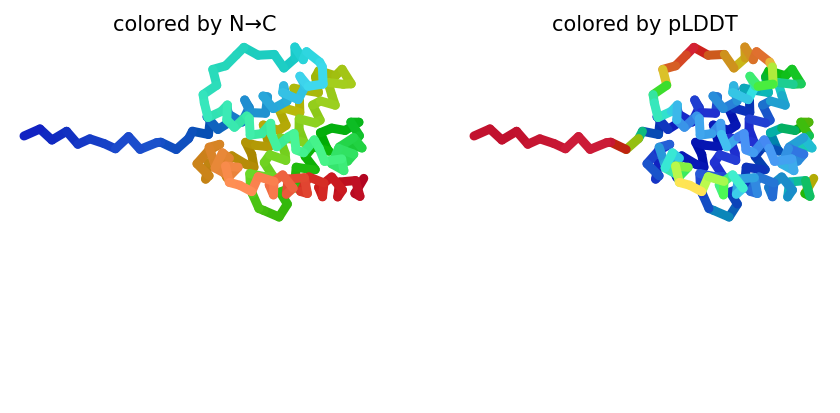

2023-12-08 01:04:54,270 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=74.4 pTM=0.721
2023-12-08 01:05:00,044 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=83.6 pTM=0.822 tol=0.98
2023-12-08 01:05:05,823 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=84.2 pTM=0.828 tol=0.401
2023-12-08 01:05:11,599 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=84 pTM=0.821 tol=0.224
2023-12-08 01:05:11,600 alphafold2_ptm_model_3_seed_000 took 23.1s (3 recycles)


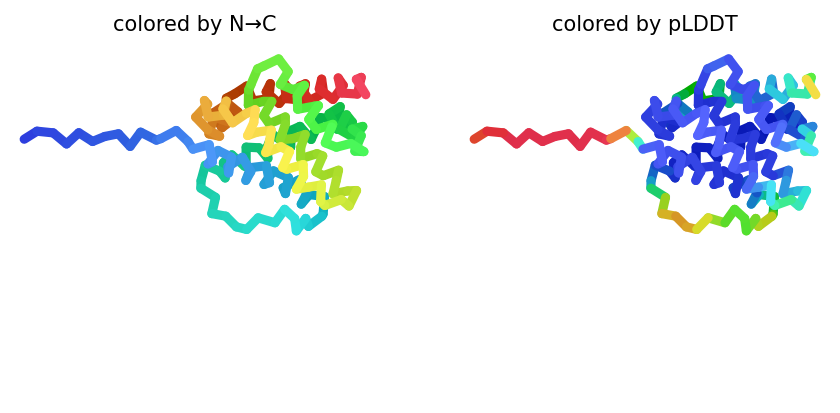

2023-12-08 01:05:17,555 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=71 pTM=0.702
2023-12-08 01:05:23,318 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=78.8 pTM=0.778 tol=0.867
2023-12-08 01:05:29,082 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=78 pTM=0.763 tol=0.439
2023-12-08 01:05:34,846 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=76.6 pTM=0.736 tol=0.257
2023-12-08 01:05:34,847 alphafold2_ptm_model_4_seed_000 took 23.1s (3 recycles)


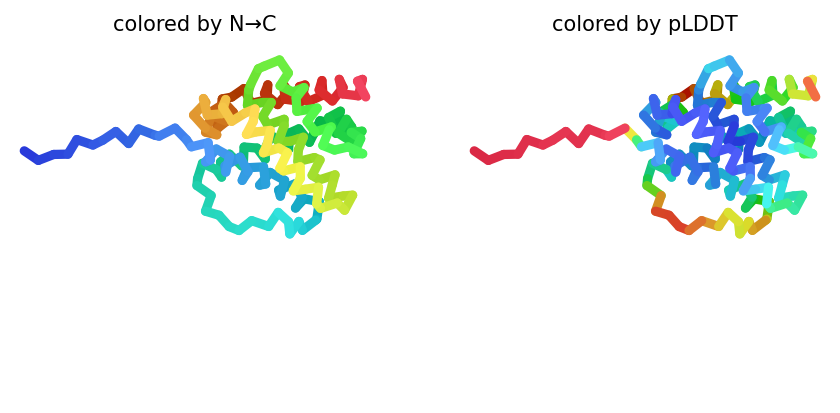

2023-12-08 01:05:40,809 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=75.6 pTM=0.776
2023-12-08 01:05:46,584 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=81.9 pTM=0.828 tol=1.01
2023-12-08 01:05:52,360 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=81.6 pTM=0.823 tol=0.38
2023-12-08 01:05:58,134 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=81.8 pTM=0.822 tol=0.216
2023-12-08 01:05:58,135 alphafold2_ptm_model_5_seed_000 took 23.1s (3 recycles)


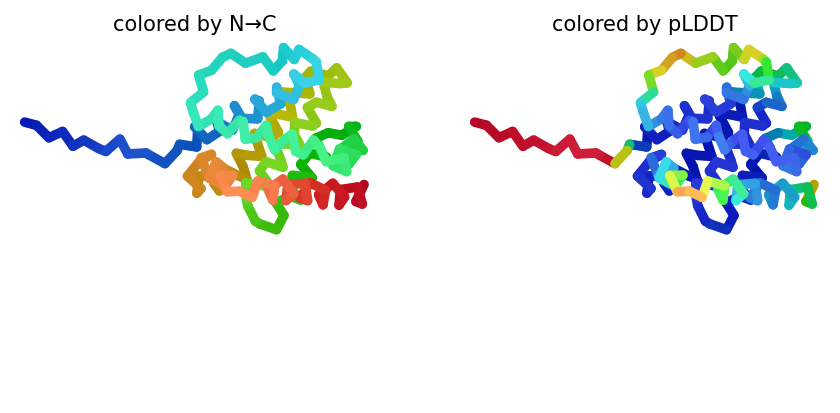

2023-12-08 01:05:58,341 reranking models by 'plddt' metric
2023-12-08 01:05:58,341 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=84 pTM=0.821
2023-12-08 01:05:58,342 rank_002_alphafold2_ptm_model_5_seed_000 pLDDT=81.8 pTM=0.822
2023-12-08 01:05:58,343 rank_003_alphafold2_ptm_model_1_seed_000 pLDDT=81.1 pTM=0.798
2023-12-08 01:05:58,343 rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=79.4 pTM=0.789
2023-12-08 01:05:58,344 rank_005_alphafold2_ptm_model_4_seed_000 pLDDT=76.6 pTM=0.736
2023-12-08 01:06:00,018 Done


0

In [ ]:
#@title # **6. Run Prediction** { display-mode: "form" }

display_images = True #@param {type:"boolean"}


import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [ ]:
# @title # **7. Visualize 3D Structure of ColabFold Prediction** { run: "auto", display-mode: "form" }

#@markdown Rank number/score for the **monomer model is the average pLDDT**,
#@markdown where a ranking of 1 correlates better local structure confidence.
#@markdown An acceptable model prediction should average $\ge 85$.
#@markdown The number of ranked models was set in step `6. Run Prediction` (step 6, line 75.).

#@markdown \
#@markdown Here, you can change the value for `rank_num` to visualize the 5 predictions.

import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list

rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "rainbow" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')


  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}}, viewer=(0,0))

  view.zoomTo()
  return view

print('Prediction: Rank %d' % rank_num)
show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


#@markdown \

Prediction: Rank 1


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
# @title # **8. Align PDBs** { run: "auto", display-mode: "form" }
#@markdown We can compare the predictions with experiment.
#@markdown Example: PDB 1F16 was obtained from NMR, so there is an ensemble of structures.

import Bio.PDB

pdb_code = "1f16" #@param{type:"string"}
#@markdown - Reference PDB (Experiment)
cpred = ""#@param{type:"string"}
#@markdown - Color for Reference PDB (Experiment)
os.system("wget -qnc https://files.rcsb.org/download/%s.pdb.gz; gunzip %s.pdb.gz" % (pdb_code,pdb_code))

start_id = 1
end_id = len(query_sequence)
atoms_to_be_aligned = range(start_id, end_id + 1)

# Start the parser
pdb_parser = Bio.PDB.PDBParser(QUIET = True)

# Get the structures
ref_structure = pdb_parser.get_structure("reference", "%s.pdb" % pdb_code)
sample_structure = pdb_parser.get_structure("sample", pdb_file[0])

# Use the first model in the pdb-files for alignment
# Change the number 0 if you want to align to another structure
ref_model    = ref_structure[0]
sample_model = sample_structure[0]

# Make a list of the atoms (in the structures) you wish to align.
# In this case we use CA atoms whose index is in the specified range
ref_atoms = []
sample_atoms = []

# Iterate of all chains in the model in order to find all residues
for ref_chain in ref_model:
  # Iterate of all residues in each model in order to find proper atoms
  for ref_res in ref_chain:
    # Check if residue number ( .get_id() ) is in the list
    if ref_res.get_id()[1] in atoms_to_be_aligned:
      # Append CA atom to list
      ref_atoms.append(ref_res['CA'])

# Do the same for the sample structure
for sample_chain in sample_model:
  for sample_res in sample_chain:
    if sample_res.get_id()[1] in atoms_to_be_aligned:
      sample_atoms.append(sample_res['CA'])

# Now we initiate the superimposer:
super_imposer = Bio.PDB.Superimposer()
super_imposer.set_atoms(ref_atoms, sample_atoms)
super_imposer.apply(sample_model.get_atoms())

# Print RMSD:
print('The calculated RMSD is: %.3f Å' % super_imposer.rms)

# Save the aligned version of one of the chains of 6ANE
io = Bio.PDB.PDBIO()
io.set_structure(sample_structure)
io.save("%s-aligned.pdb" % jobname)
print('Saved Aligned PDB.')

# rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
# #@markdown - Predicted PDB (AF/CF)
# color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
# #@markdown - Color Predicted PDB (Default: lDDT)
# tag = results["rank"][0][rank_num - 1]
# jobname_prefix = ".custom" if msa_mode == "custom" else ""
# pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
# pdb_file = glob.glob(pdb_filename)

# how_sidechains = False #@param {type:"boolean"}
# show_mainchains = False #@param {type:"boolean"}

view=py3Dmol.view()
view.addModel(open("%s-aligned.pdb" % jobname).read(),'pdb')
# view.addModel(open("%s.pdb" % pdb_code).read())
view.zoomTo()
view.setBackgroundColor('white')
view.setStyle({'chain':'A'},{'cartoon': {'color': 'red'}})
view.setStyle({'chain':'B'},{'cartoon': {'color': 'blue'}})
view.show()

# show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
# if color == "lDDT":
#   plot_plddt_legend().show()

The calculated RMSD is: 5.711 Å
Saved Aligned PDB.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
#@title **9. Package and Download**

#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Colab notebooks are adapted from:
  - [AlphaFold2 Colab](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)
  - [Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

*From the original notebook:*

> <img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">
>
> ## ColabFold v1.5.3: AlphaFold2 using MMseqs2
>
> Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and read our manuscript.
>
> Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb)
>
> [Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
> *Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)
>
> -----------
>
> ### News
> - <b><font color='green'>2023/07/31: The ColabFold MSA server is back to normal. It was using older DB (UniRef30 2202/PDB70 220313) from 27th ~8:30 AM CEST to 31st ~11:10 AM CEST.</font></b>
> - <b><font color='green'>2023/06/12: New databases! UniRef30 updated to 2023_02 and PDB to 230517. We now use PDB100 instead of PDB70 (see [notes](#pdb100)).</font></b>
> - <b><font color='green'>2023/06/12: We introduced a new default pairing strategy: Previously, for multimer predictions with more than 2 chains, we only pair if all sequences taxonomically match ("complete" pairing). The new default "greedy" strategy pairs any taxonomically matching subsets.</font></b>
>
># Instructions <a name="Instructions"></a>
>
> **Quick start**
> 1. Paste your protein sequence(s) in the input field.
> 2. Press "Runtime" -> "Run all".
> 3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.
>
> **Result zip file contents**
>
> 1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
> 2. Plots of the model quality.
> 3. Plots of the MSA coverage.
> 4. Parameter log file.
> 5. A3M formatted input MSA.
> 6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains  an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
> 7. BibTeX file with citations for all used tools and databases.
>
> At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.
>  
>
> **License**
> githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this > notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) > and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/> alphafold).
>
> **Acknowledgments**
> - We thank the AlphaFold team for developing an excellent model and open > sourcing the software.
>
> - [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.
>
> - Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.
>
> - [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!
>
> - Do-Yoon Kim for creating the ColabFold logo.
>
> - A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
>


